### Building a Recommender system with Surprise

This try-it focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to grouplens and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.



## Imports

In [55]:
from surprise import (
    Dataset,
    Reader,
    SVD,
    NMF,
    KNNBasic,
    SlopeOne,
    CoClustering,
    accuracy,
)
from surprise.model_selection import cross_validate, split, train_test_split
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})

In [2]:
# ! pip install xlrd

## Data Load

Data source is here: https://goldberg.berkeley.edu/jester-data/
- Found it by clicking off from grouplens to Jester

In [3]:
if 0:
    df = pd.read_excel("./data/jester-data-1.xls", header=None)
    df.to_csv("./data/jester-data-1.csv", index=False)
else:
    df = pd.read_csv("./data/jester-data-1.csv")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,4.13,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,3.64,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,7.28,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,3.45,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,-0.05,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,8.74,6.41,-6.36,-4.51,2.04,8.74,3.30,8.01,7.82,-1.89,3.25,2.18,1.26,8.35,3.35,-2.14,-7.91,-6.46,-3.40,5.58,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45

Select only the dense columns
> The sub-matrix including only columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense. Almost all users have rated those jokes...

In [4]:
dense_columns = [str(k) for k in [0, 5, 7, 8, 13, 15, 16, 17, 18, 19, 20]]
if 0:
    df = df[dense_columns]
    df

Use the index as user ID column

In [5]:
joke_number_names = {str(k): f"Joke {k}" for k in range(1, 101)}
df.rename(columns={"0": "Number of Jokes Rated"} | joke_number_names, inplace=True)
df

,Number of Jokes Rated,Joke 1,Joke 2,Joke 3,Joke 4,Joke 5,Joke 6,Joke 7,Joke 8,Joke 9,Joke 10,Joke 11,Joke 12,Joke 13,Joke 14,Joke 15,Joke 16,Joke 17,Joke 18,Joke 19,Joke 20,Joke 21,Joke 22,Joke 23,Joke 24,Joke 25,Joke 26,Joke 27,Joke 28,Joke 29,Joke 30,Joke 31,Joke 32,Joke 33,Joke 34,Joke 35,Joke 36,Joke 37,Joke 38,Joke 39,Joke 40,Joke 41,Joke 42,Joke 43,Joke 44,Joke 45,Joke 46,Joke 47,Joke 48,Joke 49,Joke 50,Joke 51,Joke 52,Joke 53,Joke 54,Joke 55,Joke 56,Joke 57,Joke 58,Joke 59,Joke 60,Joke 61,Joke 62,Joke 63,Joke 64,Joke 65,Joke 66,Joke 67,Joke 68,Joke 69,Joke 70,Joke 71,Joke 72,Joke 73,Joke 74,Joke 75,Joke 76,Joke 77,Joke 78,Joke 79,Joke 80,Joke 81,Joke 82,Joke 83,Joke 84,Joke 85,Joke 86,Joke 87,Joke 88,Joke 89,Joke 90,Joke 91,Joke 92,Joke 93,Joke 94,Joke 95,Joke 96,Joke 97,Joke 98,Joke 99,Joke 100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,4.13,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,3.64,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,7.28,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,3.45,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,-0.05,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [6]:
df.insert(loc=0, column="user_id", value=df.index)
df

,user_id,Number of Jokes Rated,Joke 1,Joke 2,Joke 3,Joke 4,Joke 5,Joke 6,Joke 7,Joke 8,Joke 9,Joke 10,Joke 11,Joke 12,Joke 13,Joke 14,Joke 15,Joke 16,Joke 17,Joke 18,Joke 19,Joke 20,Joke 21,Joke 22,Joke 23,Joke 24,Joke 25,Joke 26,Joke 27,Joke 28,Joke 29,Joke 30,Joke 31,Joke 32,Joke 33,Joke 34,Joke 35,Joke 36,Joke 37,Joke 38,Joke 39,Joke 40,Joke 41,Joke 42,Joke 43,Joke 44,Joke 45,Joke 46,Joke 47,Joke 48,Joke 49,Joke 50,Joke 51,Joke 52,Joke 53,Joke 54,Joke 55,Joke 56,Joke 57,Joke 58,Joke 59,Joke 60,Joke 61,Joke 62,Joke 63,Joke 64,Joke 65,Joke 66,Joke 67,Joke 68,Joke 69,Joke 70,Joke 71,Joke 72,Joke 73,Joke 74,Joke 75,Joke 76,Joke 77,Joke 78,Joke 79,Joke 80,Joke 81,Joke 82,Joke 83,Joke 84,Joke 85,Joke 86,Joke 87,Joke 88,Joke 89,Joke 90,Joke 91,Joke 92,Joke 93,Joke 94,Joke 95,Joke 96,Joke 97,Joke 98,Joke 99,Joke 100
0,0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,4.13,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,3.64,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,7.28,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,3.45,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,-0.05,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Melt the data to turn the joke number into a "title"

In [7]:
melted_df = pd.melt(
    df,
    id_vars="user_id",
    value_vars=list(joke_number_names.values()),
    var_name="Title",
    value_name="Rating",
).reset_index(drop=True)
melted_df

,user_id,Title,Rating
0,0,Joke 1,-7.82
1,1,Joke 1,4.08
2,2,Joke 1,99.00
3,3,Joke 1,99.00
4,4,Joke 1,8.50
...,...,...,...
2498295,24978,Joke 100,7.43
2498296,24979,Joke 100,8.45
2498297,24980,Joke 100,99.00
2498298,24981,Joke 100,99.00


Remove ratings of 99 which correspond to no rating

In [8]:
melted_df = melted_df.query("Rating != 99").reset_index(drop=True)
melted_df

,user_id,Title,Rating
0,0,Joke 1,-7.82
1,1,Joke 1,4.08
2,4,Joke 1,8.50
3,5,Joke 1,-6.17
4,7,Joke 1,6.84
...,...,...,...
1810450,24967,Joke 100,-0.68
1810451,24971,Joke 100,4.37
1810452,24976,Joke 100,9.27
1810453,24978,Joke 100,7.43


To speed up the development, take a random 10% shuffle of the data

In [9]:
melted_df = melted_df.sample(frac=0.1, random_state=42)
melted_df

,user_id,Title,Rating
22983,8973,Joke 2,0.73
95103,4158,Joke 6,0.19
1431288,18234,Joke 66,3.25
528971,8168,Joke 25,0.05
1223791,15132,Joke 56,-3.79
...,...,...,...
1425638,12571,Joke 66,-1.55
212761,16610,Joke 11,-8.74
617092,1440,Joke 29,9.32
1401820,13607,Joke 65,1.31


## Loop Over Available Algorithms

In [10]:
data = Dataset.load_from_df(
    melted_df[["user_id", "Title", "Rating"]], Reader(rating_scale=(-10, 10))
)

In [16]:
algo_list = [
    "SVD",
    "NMF",
    # "KNNBasic", # --> crashing
    "SlopeOne",
    "CoClustering",
]

In [17]:
results_list = []
for algo_name in algo_list:
    print(f"\nRunning algorithm {algo_name}")
    kwargs = {"random_state": 42} if algo_name != "SlopeOne" else {}
    algo = eval(algo_name)(**kwargs)
    cv = split.KFold(random_state=42)
    t0 = time.time()
    cv_results = cross_validate(algo, data, measures=["rmse"], cv=cv, verbose=True)
    results_list.append(
        {
            "Algorithm": algo_name,
            "RMSE": cv_results["test_rmse"].mean(),
            "Fit and Test Time": time.time() - t0,
        }
    )


Running algorithm SVD
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.6774  4.6632  4.6776  4.6845  4.6668  4.6739  0.0078  
Fit time          1.47    1.27    1.37    1.36    1.31    1.36    0.07    
Test time         0.17    0.32    0.16    0.29    0.17    0.22    0.07    

Running algorithm NMF
Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.4202  5.3834  5.4462  5.3341  5.3813  5.3930  0.0382  
Fit time          3.97    4.01    3.92    3.83    3.80    3.91    0.08    
Test time         0.13    0.27    0.27    0.31    0.13    0.22    0.07    

Running algorithm SlopeOne
Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.7436  4.7247  4.7300  4.7467  4.7310  4.7352  0.0085  
Fit time          0.23  

In [18]:
pd.DataFrame(results_list)

,Algorithm,RMSE,Fit and Test Time
0,SVD,4.673891,9.008748
1,NMF,5.393032,21.755871
2,SlopeOne,4.735189,4.496868
3,CoClustering,4.869644,22.373126


## Make Some Plots

Just look at SVD and SlopeOne since those had the best scores and fit times

In [43]:
def extract_results(surprise_predictions: list) -> tuple[np.array, np.array]:
    return (
        np.array(
            [surprise_predictions[k].r_ui for k in range(len(surprise_predictions))]
        ),
        np.array(
            [surprise_predictions[k].est for k in range(len(surprise_predictions))]
        ),
    )

In [44]:
trainset, testset = train_test_split(data, test_size=0.25)

In [46]:
algo_name = "SVD"
algo = eval(algo_name)(random_state=42)
algo.fit(trainset)
predictions = algo.test(testset)
predictions[:5]

[Prediction(uid=3670, iid='Joke 50', r_ui=1.84, est=3.3229950729999658, details={'was_impossible': False}),
 Prediction(uid=14314, iid='Joke 66', r_ui=4.47, est=2.7433821541578545, details={'was_impossible': False}),
 Prediction(uid=4167, iid='Joke 25', r_ui=1.99, est=-0.27384577887465544, details={'was_impossible': False}),
 Prediction(uid=4477, iid='Joke 70', r_ui=3.5, est=0.7833188153631512, details={'was_impossible': False}),
 Prediction(uid=23152, iid='Joke 29', r_ui=3.54, est=-1.6726338578029276, details={'was_impossible': False})]

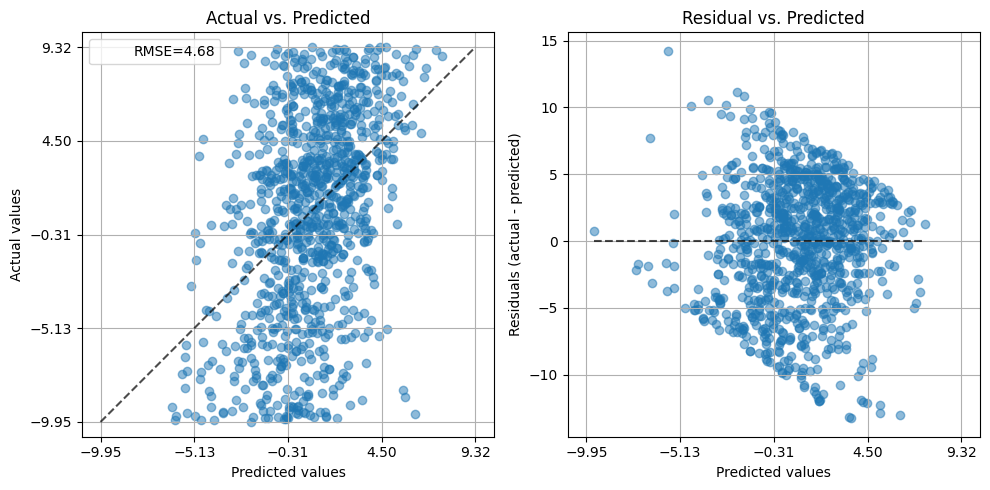

In [54]:
f, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

y_true, y_pred = extract_results(predictions)

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)

ax0.set_title("Actual vs. Predicted")

# Add the score in the legend of each axis
ax0.plot([], [], " ", label=f"RMSE={accuracy.rmse(predictions, verbose=False):.2f}")
ax0.legend(loc="upper left")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

ax1.set_title("Residual vs. Predicted")

plt.tight_layout()
plt.show()